In [83]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
# import os

In [27]:
uber_apr = pd.read_csv('../input/uber-raw-data-apr14.csv')
uber_may = pd.read_csv('../input/uber-raw-data-may14.csv')
uber_jun = pd.read_csv('../input/uber-raw-data-jun14.csv')
uber_jul = pd.read_csv('../input/uber-raw-data-jul14.csv')
uber_aug = pd.read_csv('../input/uber-raw-data-aug14.csv')
uber_sep = pd.read_csv('../input/uber-raw-data-sep14.csv')


### Plotting trips of for all 6 months:

In [28]:
all_dfs = [uber_apr, uber_may, uber_jun, uber_jul, uber_aug, uber_sep]
# all_dfs = [uber_apr, uber_may]
del uber_apr,uber_may, uber_jun, uber_jul, uber_aug, uber_sep

def get_trips(df_names):
    
    months_trips =  np.empty((31, 6))
    
    for ind, name in enumerate(df_names):
#         days = [datetime.strptime(pickup, '%m/%d/%Y %H:%M:%S').day for pickup in name['Date/Time']]        
        days = name['Date/Time'].apply(lambda pickup: datetime.strptime(pickup, '%m/%d/%Y %H:%M:%S').day)
        count_days = list(Counter(days).values())
        try:
            months_trips[:, ind] = count_days
        except:
            months_trips[0:-1, ind] = count_days
            months_trips[-1, ind] = np.nan
    
    return months_trips

months_trips = get_trips(all_dfs)

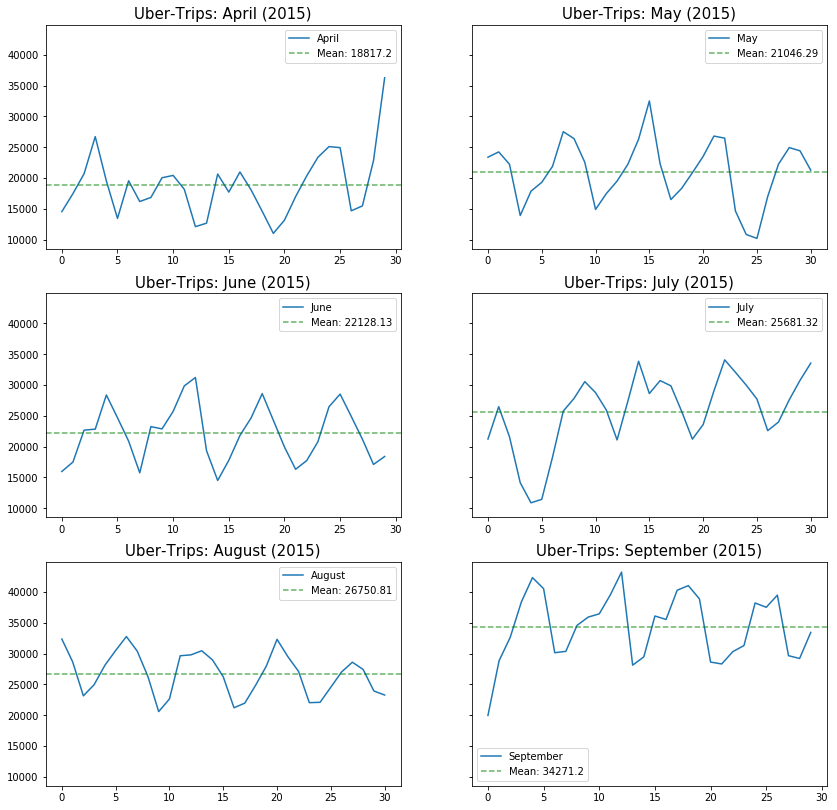

In [29]:
def plot_trips(trips_mat):    
    months = ['April', 'May', 'June', 'July', 'August', 'September']
    months_trips_df = pd.DataFrame(trips_mat, columns = months)

    fig, ax = plt.subplots(figsize = (14,14), ncols = 2, nrows = 3, sharey = True)
    mon = 0
    for row in range(3):
        for col in range(2):
            months_trips_df.iloc[:,mon].plot(ax = ax[row, col])
            ax[row,col].set_title('Uber-Trips: {} (2015)'.format(months[mon]), fontsize = 15)
            ax[row,col].axhline(y = np.mean(months_trips_df.iloc[:,mon]), linestyle = 'dashed',
                                color = 'g', alpha = 0.6, 
                                label = 'Mean: {}'.format(round(np.mean(months_trips_df.iloc[:,mon]),2)))
            ax[row,col].legend()

            mon+=1
    plt.show()
    
    return months_trips_df

months_trips_df = plot_trips(months_trips)

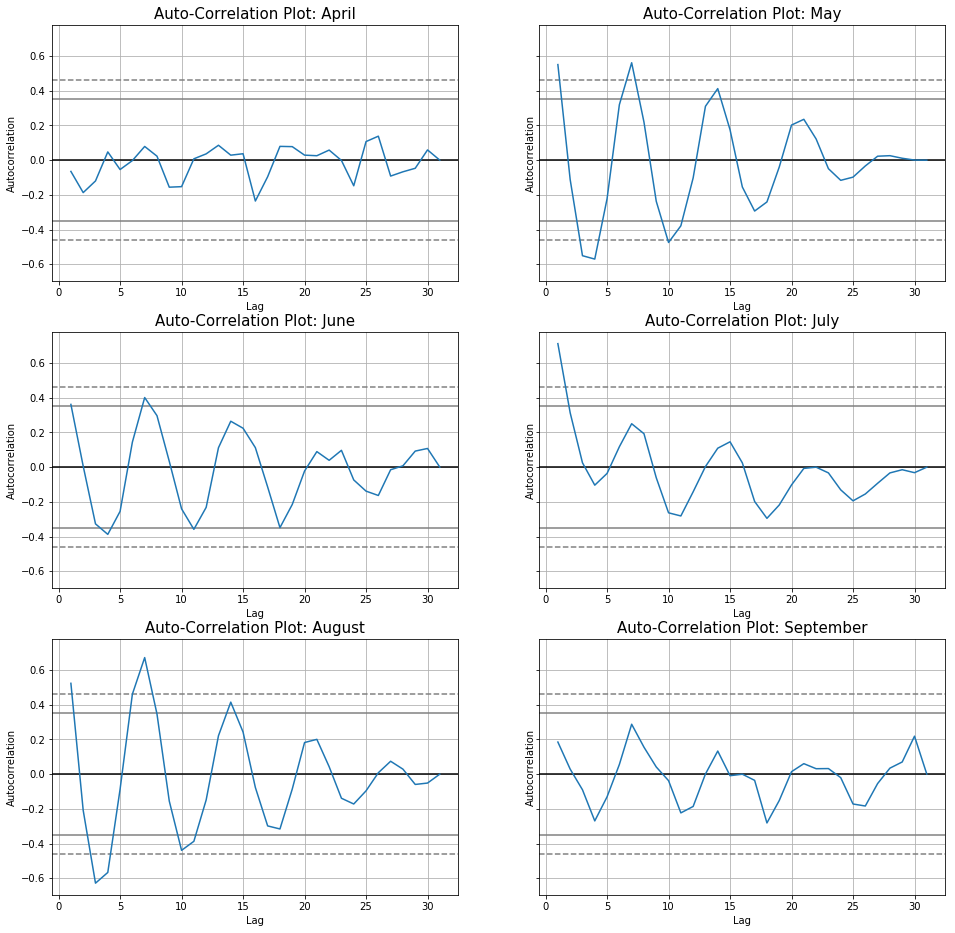

In [30]:
from pandas.plotting import autocorrelation_plot as acp
months = ['April', 'May', 'June', 'July', 'August', 'September']

fig, ax = plt.subplots(figsize = (16,16), ncols = 2, nrows = 3, sharey = True)
mon = 0
months_trips_df.fillna(0, inplace=True)
for row in range(3):
    for col in range(2):
        acp(months_trips_df.iloc[:,mon], ax = ax[row,col])
        ax[row,col].set_title('Auto-Correlation Plot: {}'.format(months[mon]), fontsize = 15)
        mon+=1

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


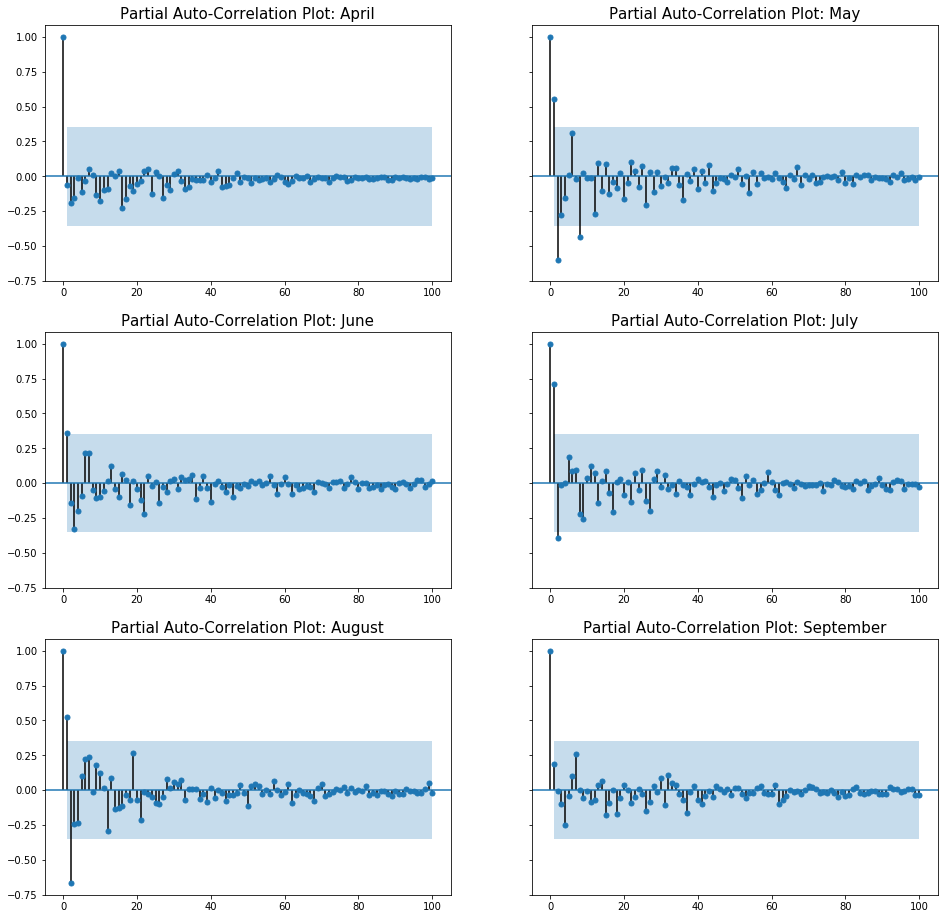

In [31]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize = (16,16), ncols = 2, nrows = 3, sharey = True)
mon = 0
for row in range(3):
    for col in range(2):
        plot_pacf(months_trips_df.iloc[:,mon], ax = ax[row,col], lags = 100)
        ax[row,col].set_title('Partial Auto-Correlation Plot: {}'.format(months[mon]), fontsize = 15)
        mon+=1

## Analysis with all the months combined:

In [32]:
all_uber_trips = [list(months_trips_df.iloc[:,i]) for i in range(6)]
all_uber_trips_2 = [count for trips in all_uber_trips for count in trips]
all_uber_trips_2 = [count for count in all_uber_trips_2 if count != 0]
len(all_uber_trips_2)

183

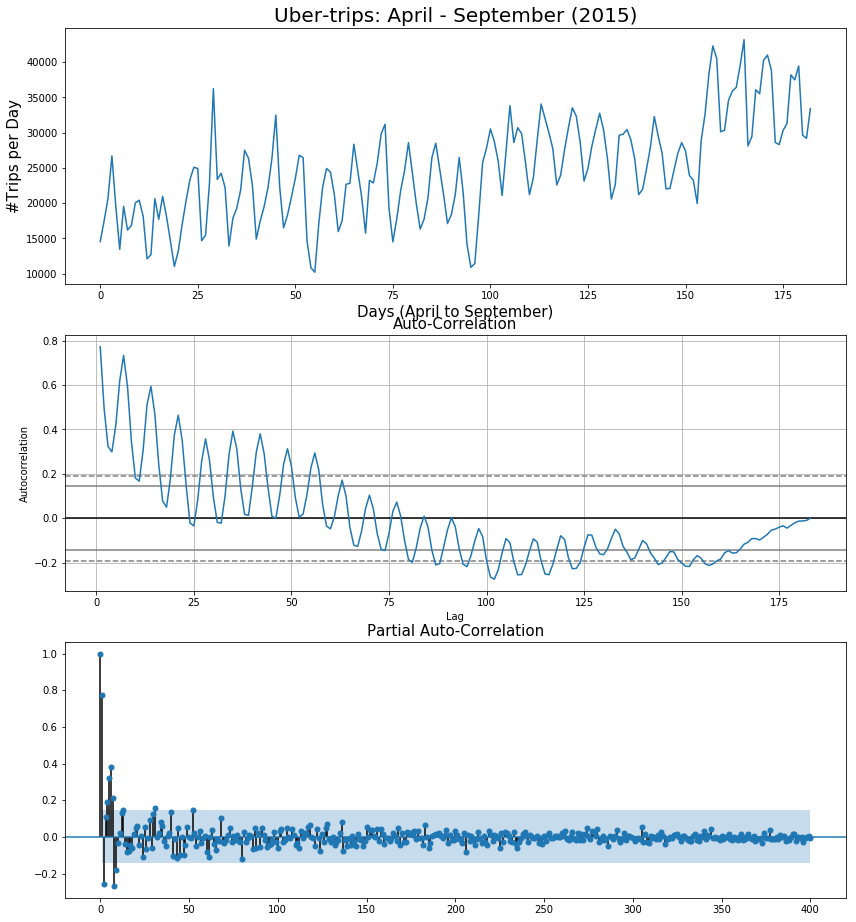

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (14,16), nrows = 3)
ax1.plot(all_uber_trips_2)
ax1.set_xlabel('Days (April to September)', fontsize = 15)
ax1.set_ylabel('#Trips per Day', fontsize = 15)
ax1.set_title('Uber-trips: April - September (2015)', fontsize = 20)

# fig, (ax1, ax2) = plt.subplots(figsize = (14,12), nrows = 2)
acp(all_uber_trips_2, ax = ax2)
ax2.set_title('Auto-Correlation', fontsize = 15)

plot_pacf(all_uber_trips_2, ax = ax3, lags = 400)
ax3.set_title('Partial Auto-Correlation', fontsize = 15)

plt.show()

### +ve correlation at shor-term values  and -ve correlation at lon-term values.
### It's an indication of trend.
### So, we need to detrend the time-series before analysis.

In [34]:
all_trips_df = pd.DataFrame(all_uber_trips_2)
all_trips_df.columns = ['Trips']

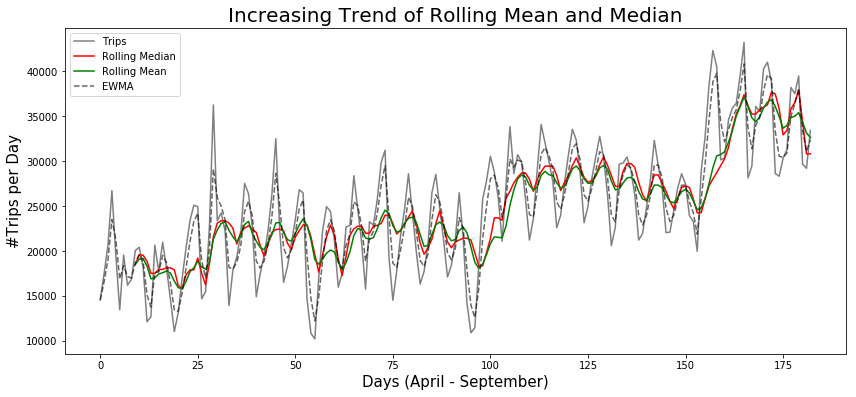

In [35]:
r = all_trips_df.rolling(window = 10)

fig, ax = plt.subplots(figsize = (14,6))

all_trips_df['Trips'].plot(color = 'gray', ax = ax, label = 'Trips')
r.median()['Trips'].plot(color = 'red', ax = ax, label = 'Rolling Median')
r.mean()['Trips'].plot(color = 'green', ax = ax, label = 'Rolling Mean')
all_trips_df['Trips'].ewm(com = 0.8).mean().plot(ax = ax, color = 'black', linestyle = 'dashed', alpha = 0.6, label = 'EWMA')

ax.set_xlabel('Days (April - September)', fontsize = 15)
ax.set_ylabel('#Trips per Day', fontsize = 15)
ax.set_title('Increasing Trend of Rolling Mean and Median', fontsize = 20)
ax.legend()

plt.show()


## Moving further with de-trending:

### Following plot gives almost stationary (mean and variance) time-series:

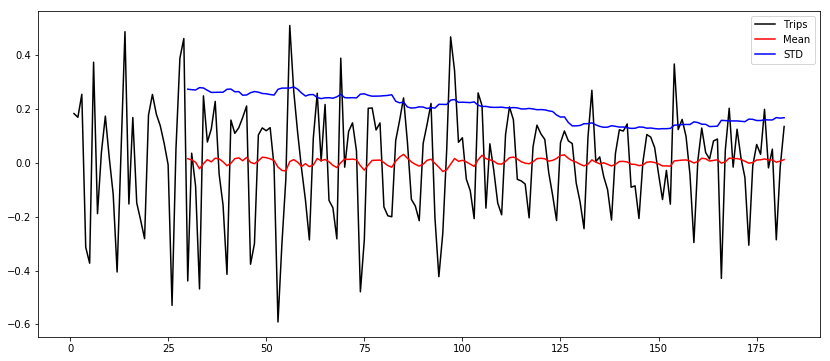

In [36]:
log_all_trips_df = np.log(all_trips_df)
log_all_trips_df_diff = log_all_trips_df - log_all_trips_df.shift()

fig, ax = plt.subplots(figsize = (14, 6))
log_all_trips_df_diff.plot(ax = ax, color = 'k')
r2 = log_all_trips_df_diff.rolling(window = 30)
r2.mean()['Trips'].plot(color = 'red', ax = ax, label = 'Mean')
r2.std()['Trips'].plot(color = 'blue', ax = ax, label = 'STD')

# for i in range(7,175,7):
#     ax.axvline(x = i, linestyle = 'dashed', color = 'k', alpha = 0.5)

ax.legend()
plt.show()

### Following plot helps in understanding the reason behind periodic spikes or the  internal structure.

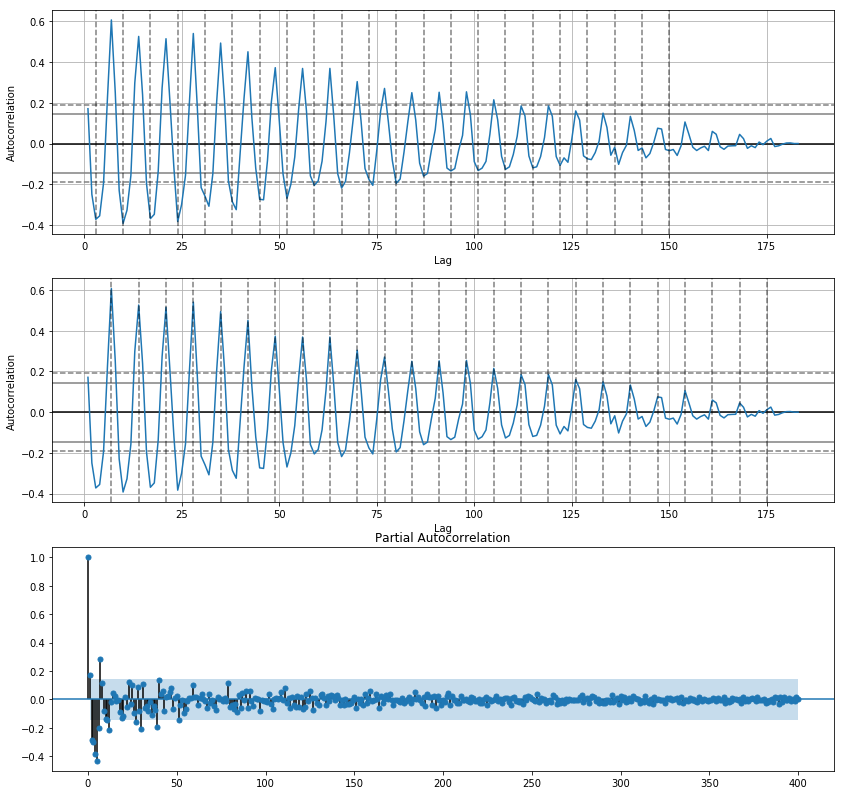

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (14,14), nrows = 3)

log_all_trips_df_diff.fillna(0, inplace = True)
acp(log_all_trips_df_diff, ax = ax1)
for i in range(3,153,7):
    ax1.axvline(x = i, linestyle = 'dashed', color = 'k', alpha = 0.5)

acp(log_all_trips_df_diff, ax = ax2)
for i in range(7,177,7):
    ax2.axvline(x = i, linestyle = 'dashed', color = 'k', alpha = 0.5)

plot_pacf(log_all_trips_df_diff, ax = ax3, lags = 400)

plt.show()

In [38]:
from statsmodels.tsa.stattools import adfuller
imp_stats = list(adfuller(log_all_trips_df_diff['Trips'], autolag = 'AIC', regression = 'c')[0:4])
values = ['Test-statistic', 'p-Value','#Lags', '#Obs.']
pd.DataFrame({'Stats': values, 
              'Values': imp_stats})

,Stats,Values
0,Test-statistic,-6.683545e+00
1,p-Value,4.282167e-09
2,#Lags,1.100000e+01
3,#Obs.,1.710000e+02


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


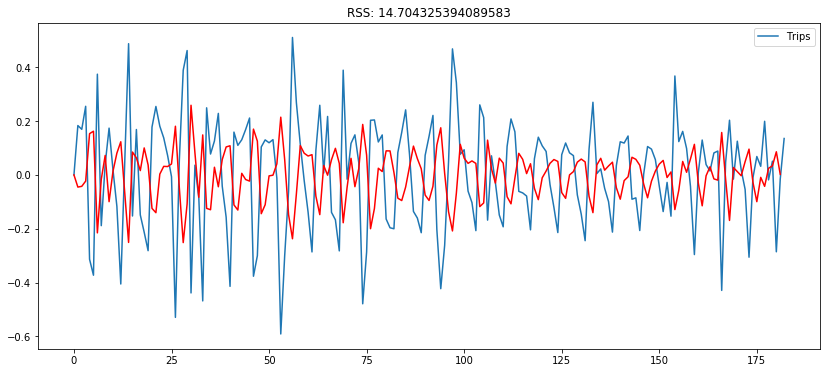

In [39]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(np.array(log_all_trips_df_diff['Trips']), order = (2,1,0))
results_arima = model.fit(disp = -1)

fig, ax = plt.subplots(figsize = (14,6))
log_all_trips_df_diff.plot(ax = ax)
ax.plot(results_arima.fittedvalues, color = 'red')
ax.set_title('RSS: {}'.format(np.sum((results_arima.fittedvalues - log_all_trips_df_diff['Trips'][:-1])**2)))
plt.show()

### Need to bring back the transformations (differencing and log) to actual values
### Try to understand the results of current analysis
### Segregate train and test data
### Repeat this analysis for Jan-June 2015

In [2]:
uber_jan_june = pd.read_csv('../input/uber-raw-data-janjune-15.csv')
print (uber_jan_june.head())
uber_jan_june.shape

  Dispatching_base_num          Pickup_date Affiliated_base_num  locationID
0               B02617  2015-05-17 09:47:00              B02617         141
1               B02617  2015-05-17 09:47:00              B02617          65
2               B02617  2015-05-17 09:47:00              B02617         100
3               B02617  2015-05-17 09:47:00              B02774          80
4               B02617  2015-05-17 09:47:00              B02617          90


(14270479, 4)

In [3]:
uber_jan_june['Month_Day'] = uber_jan_june['Pickup_date'].apply(lambda pickup: datetime.strptime(pickup, '%Y-%m-%d %H:%M:%S').strftime('%m-%d').split('-'))

In [4]:
uber_jan_june['Month'] = [month_day [0] for month_day in uber_jan_june['Month_Day']]
uber_jan_june['Day'] = [month_day [1] for month_day in uber_jan_june['Month_Day']]
uber_jan_june.tail(20)

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Month_Day,Month,Day
14270459,B02765,2015-05-08 15:40:00,B02765,186,"[05, 08]",05,08
14270460,B02765,2015-05-08 15:41:00,B02764,50,"[05, 08]",05,08
14270461,B02765,2015-05-08 15:41:00,B02253,13,"[05, 08]",05,08
14270462,B02765,2015-05-08 15:41:00,B02682,192,"[05, 08]",05,08
14270463,B02765,2015-05-08 15:41:00,B02345,262,"[05, 08]",05,08
14270464,B02765,2015-05-08 15:41:00,B02765,237,"[05, 08]",05,08
14270465,B02765,2015-05-08 15:41:00,B02765,233,"[05, 08]",05,08
14270466,B02765,2015-05-08 15:41:00,B02765,148,"[05, 08]",05,08
14270467,B02765,2015-05-08 15:41:00,B02765,33,"[05, 08]",05,08
14270468,B02765,2015-05-08 15:42:00,B02096,232,"[05, 08]",05,08


In [84]:
jan_june_grouped = uber_jan_june.groupby(by = ['Month', 'Day']).size().unstack()
jan_june_grouped

Day,01,02,03,04,05,06,07,08,09,10,...,22,23,24,25,26,27,28,29,30,31
Month,,,,,,,,,,,,,,,,,,,,,
01,58045.0,40287.0,59844.0,41943.0,43678.0,53539.0,63375.0,73016.0,72124.0,80656.0,...,66819.0,73363.0,82588.0,59382.0,44310.0,25954.0,61626.0,70441.0,85565.0,94448.0
02,78592.0,70193.0,71532.0,68237.0,82336.0,87568.0,82752.0,64327.0,63306.0,66197.0,...,67844.0,72494.0,80520.0,75992.0,84840.0,90217.0,89716.0,NaN,NaN,NaN
03,70839.0,57460.0,75048.0,71931.0,77446.0,83134.0,81468.0,61824.0,53920.0,72185.0,...,69337.0,60498.0,64400.0,73953.0,78552.0,84977.0,92527.0,75648.0,62780.0,78893.0
04,69223.0,74069.0,75983.0,69189.0,58357.0,53565.0,68079.0,72023.0,77520.0,81439.0,...,82124.0,92110.0,99688.0,106270.0,88673.0,64783.0,68863.0,75940.0,84330.0,NaN
05,92329.0,104978.0,80300.0,65447.0,76195.0,80447.0,87361.0,90733.0,98359.0,80146.0,...,85771.0,78343.0,68328.0,59748.0,72820.0,88662.0,95074.0,98200.0,104429.0,96947.0
06,93499.0,97592.0,87206.0,95023.0,101922.0,101773.0,88876.0,76899.0,82463.0,87403.0,...,75418.0,93172.0,91388.0,100073.0,99508.0,136193.0,93108.0,74430.0,82627.0,NaN


In [6]:
all_jan_june = [jan_june_grouped.iloc[r,:] for r in range(jan_june_grouped.shape[0])]
all_jan_june = [trips for month in all_jan_june for trips in month]
len(all_jan_june)

186

In [7]:
remove_inds = list(np.argwhere(np.isnan(all_jan_june) == True).reshape((1,5))[0])
all_jan_june_mod = [all_jan_june[i] for i,j in enumerate(all_jan_june) if i not in remove_inds]

In [8]:
print (len(all_jan_june_mod))

181


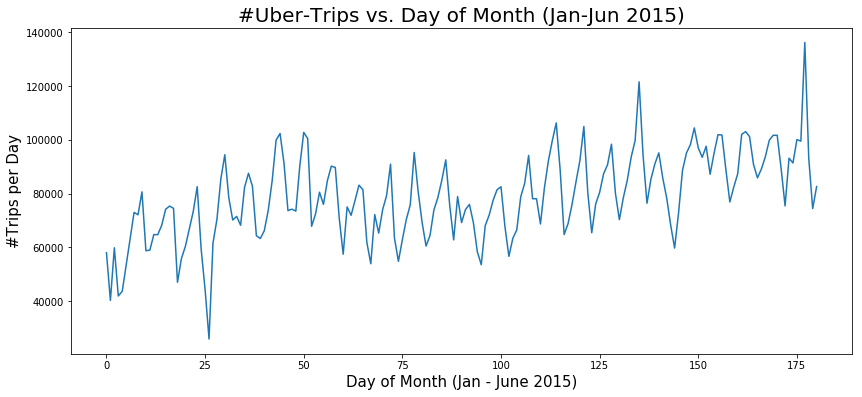

In [19]:
fig, ax = plt.subplots(figsize = (14,6))
ax.plot(all_jan_june_mod)
ax.set_xlabel('Day of Month (Jan - June 2015)', fontsize = 15)
ax.set_ylabel('#Trips per Day', fontsize = 15)
ax.set_title('#Uber-Trips vs. Day of Month (Jan-Jun 2015)', fontsize = 20)
plt.show()

In [9]:
uber_jan_june_final = pd.DataFrame({'Days': range(1,len(all_jan_june_mod)+1), 'Trips': all_jan_june_mod})
uber_jan_june_final.head()
# uber_jan_june_final.to_csv('uber_jan_june_final', index=False)

,Days,Trips
0,1,58045.0
1,2,40287.0
2,3,59844.0
3,4,41943.0
4,5,43678.0


In [40]:
uber_jan_june_final['Trips_log'] = np.log(uber_jan_june_final['Trips'])
uber_jan_june_final['Shifted'] = uber_jan_june_final['Trips_log'] - uber_jan_june_final['Trips_log'].shift()
uber_jan_june_final.head()

,Days,Trips,Trips_log,Shifted
0,1,58045.0,10.968974,NaN
1,2,40287.0,10.603784,-0.365190
2,3,59844.0,10.999496,0.395712
3,4,41943.0,10.644067,-0.355430
4,5,43678.0,10.684600,0.040533


In [41]:
temp = uber_jan_june_final[['Shifted']][0:10]
temp.cumsum()

,Shifted
0,NaN
1,-0.365190
2,0.030523
3,-0.324907
4,-0.284374
5,-0.080808
6,0.087851
7,0.229460
8,0.217168
9,0.328975


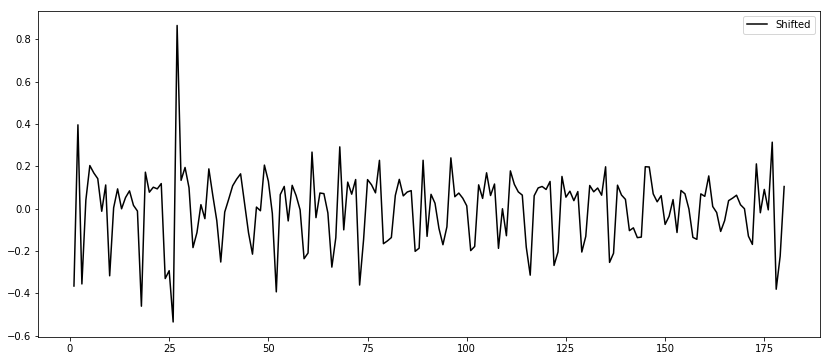

In [42]:
fig, ax = plt.subplots(figsize = (14, 6))
uber_jan_june_final['Shifted'][1:].plot(ax = ax, color = 'k')
# r3 = uber_jan_june_final['Shifted'][1:].rolling(window = 30)
# r3.mean()['Shifted'].plot(color = 'red', ax = ax, label = 'Mean')
# r3.std()['Shifted'].plot(color = 'blue', ax = ax, label = 'STD')

# for i in range(7,175,7):
#     ax.axvline(x = i, linestyle = 'dashed', color = 'k', alpha = 0.5)

ax.legend()
plt.show()

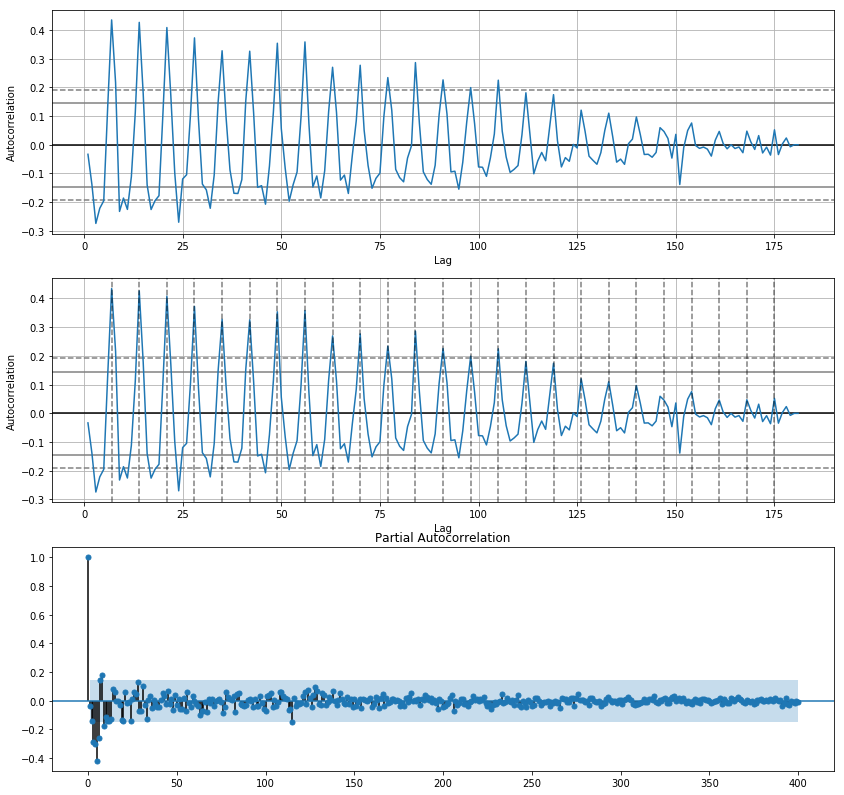

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (14,14), nrows = 3)

uber_jan_june_final['Shifted'].fillna(0, inplace = True)
acp(uber_jan_june_final['Shifted'], ax = ax1)
# for i in range(3,153,7):
#     ax1.axvline(x = i, linestyle = 'dashed', color = 'k', alpha = 0.5)

acp(uber_jan_june_final['Shifted'], ax = ax2)
for i in range(7,177,7):
    ax2.axvline(x = i, linestyle = 'dashed', color = 'k', alpha = 0.5)

plot_pacf(uber_jan_june_final['Shifted'], ax = ax3, lags = 400)

plt.show()

In [ ]:
# days_2015 = [datetime.strptime(pickup, '%m/%d/%Y %H:%M:%S').day for pickup in uber_jan_june['Date/Time']]        
# days_2015 = uber_jan_june['Pickup_date'].apply(lambda pickup: datetime.strptime(pickup, '%Y-%m-%d %H:%M:%S').day)

# count_days_2015 = list(Counter(days_2015).values())
# uber_jan_june = pd.DataFrame(list(dict(Counter(days_2015)).items()), columns = ['Day', 'Trips']).sort_values(by = 'Day').reset_index(drop = True)
# uber_jan_june

KeyError: 'Trips'

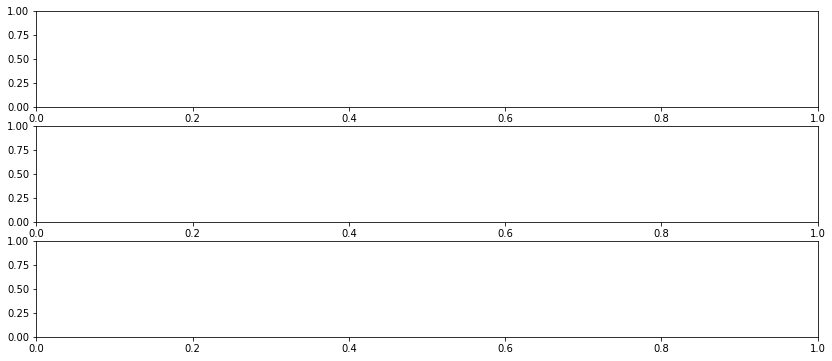

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (14,6), nrows = 3)
ax1.plot(uber_jan_june['Trips'])
ax1.set_xlabel('Days (January to June)', fontsize = 15)
ax1.set_ylabel('#Trips per Day', fontsize = 15)
ax1.set_title('Uber-trips: April - September (2015)', fontsize = 20)

acp(uber_jan_june['Trips'], ax = ax2)
ax2.set_title('Auto-Correlation', fontsize = 15)

plot_pacf(uber_jan_june['Trips'], ax = ax3, lags = 400)
ax3.set_title('Partial Auto-Correlation', fontsize = 15)

plt.show()

## Setting up LSTM:
### Data Pre-processing:

In [10]:
from sklearn.preprocessing import MinMaxScaler

## Split into train-test set:
train_jan_june = uber_jan_june_final.iloc[0:167,1:2].values
test_jan_june = uber_jan_june_final.iloc[167:,1:2].values

print ('Training data: ', train_jan_june.shape)
print ('Testing data: ', test_jan_june.shape)

## Feature-scaling:
mms = MinMaxScaler(feature_range = (0,1))
train_jan_june_scaled = mms.fit_transform(train_jan_june)

Training data:  (167, 1)
Testing data:  (14, 1)


In [77]:
## Create structured training set:
x_train = []
y_train = []

for rides in range(14, 167):
    x_train.append(train_jan_june_scaled[rides-14:rides,0])
    y_train.append(train_jan_june_scaled[rides,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, newshape = (x_train.shape[0], x_train.shape[1], 1))

In [53]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import GridSearchCV

### Build RNN:

In [ ]:
## units = 25, dropout = 0.1, optimizer = adam, epochs = 500
## units = 25, dropout = 0.1, optimizer = rmsprop, epochs = 500
## units = 40, dropout = 0.1, optimizer = adam, epochs = 500
## units = 40, dropout = 0.2, optimizer = adam, epochs = 500
## units = 40, dropout = 0.2, optimizer = adam, epochs = 500
## units = 40, dropout = 0.2, optimizer = adam, epochs = 500, batch_size = 16------best


In [227]:
np.random.seed(11)

# def grid_search_lstm():
regressor = Sequential()

## Adding first LSTM layer:
regressor.add(LSTM(units = 40, return_sequences = True, input_shape = (x_train.shape[1],1)))
regressor.add(Dropout(0.2))

## Adding second LSTM layer:
regressor.add(LSTM(units = 40, return_sequences = True))
regressor.add(Dropout(0.2))

## Adding third LSTM layer:
regressor.add(LSTM(units = 40, return_sequences = True))
regressor.add(Dropout(0.2))

## Adding fourth LSTM layer:
regressor.add(LSTM(units = 40, return_sequences = True))
regressor.add(Dropout(0.2))

## Adding fifth LSTM layer:
regressor.add(LSTM(units = 40, return_sequences = False))
regressor.add(Dropout(0.2))

## Adding o/p layer:
regressor.add(Dense(units = 1))

## Compiling RNN:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Fitting RNN to training set:
regressor.fit(x = x_train, y = y_train, epochs = 1000, batch_size = 16)

#     return regressor

# parameters = {'batch_size': [32,64], 'epochs': [20,50,80,100], 'optimizer': ['adam', 'rmsprop']}


Epoch 1/1000
153/153 [==============================] - 18s 117ms/step - loss: 0.1987
Epoch 2/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0432
Epoch 3/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0361
Epoch 4/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0250
Epoch 5/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0267
Epoch 6/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0249
Epoch 7/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0267
Epoch 8/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0222
Epoch 9/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0236
Epoch 10/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0236
Epoch 11/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0239
Epoch 12/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.023

153/153 [==============================] - 1s 6ms/step - loss: 0.0182
Epoch 99/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0200
Epoch 100/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0185
Epoch 101/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0215
Epoch 102/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0190
Epoch 103/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0195
Epoch 104/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0190
Epoch 105/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0184
Epoch 106/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0162
Epoch 107/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0179
Epoch 108/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0172
Epoch 109/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0

153/153 [==============================] - 1s 7ms/step - loss: 0.0162
Epoch 195/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0166
Epoch 196/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0177
Epoch 197/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0159
Epoch 198/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0171
Epoch 199/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0162
Epoch 200/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0159
Epoch 201/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0172
Epoch 202/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0154
Epoch 203/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0157
Epoch 204/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0159
Epoch 205/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.

153/153 [==============================] - 1s 6ms/step - loss: 0.0142
Epoch 291/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0139
Epoch 292/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0137
Epoch 293/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0137
Epoch 294/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0131
Epoch 295/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0132
Epoch 296/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0133
Epoch 297/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0142
Epoch 298/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0136
Epoch 299/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0131
Epoch 300/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0119
Epoch 301/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.

153/153 [==============================] - 1s 7ms/step - loss: 0.0119
Epoch 387/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0128
Epoch 388/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0115
Epoch 389/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0121
Epoch 390/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0115
Epoch 391/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0115
Epoch 392/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0120
Epoch 393/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0118
Epoch 394/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0118
Epoch 395/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0120
Epoch 396/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0125
Epoch 397/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.

Epoch 482/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0113
Epoch 483/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0113
Epoch 484/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0109
Epoch 485/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0106
Epoch 486/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0105
Epoch 487/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0110
Epoch 488/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0108
Epoch 489/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0112
Epoch 490/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0118
Epoch 491/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0108
Epoch 492/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0107
Epoch 493/1000
153/153 [==============================] - 1s 7ms/

153/153 [==============================] - 1s 7ms/step - loss: 0.0105
Epoch 578/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0106
Epoch 579/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0116
Epoch 580/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0107
Epoch 581/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0114
Epoch 582/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0102
Epoch 583/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0108
Epoch 584/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0099
Epoch 585/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0102
Epoch 586/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0103
Epoch 587/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0103
Epoch 588/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.

Epoch 673/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0099
Epoch 674/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0092
Epoch 675/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0098
Epoch 676/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0093
Epoch 677/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0085
Epoch 678/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0091
Epoch 679/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0089
Epoch 680/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0092
Epoch 681/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0104
Epoch 682/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0115
Epoch 683/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0105
Epoch 684/1000
153/153 [==============================] - 1s 7ms/

153/153 [==============================] - 1s 7ms/step - loss: 0.0079
Epoch 770/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0085
Epoch 771/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0070
Epoch 772/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0079
Epoch 773/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0081A: 0s - loss: 0.008
Epoch 774/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0073
Epoch 775/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0074
Epoch 776/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0072
Epoch 777/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0069
Epoch 778/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0084
Epoch 779/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0080
Epoch 780/1000
153/153 [==============================] - 1s 

153/153 [==============================] - 1s 6ms/step - loss: 0.0069
Epoch 866/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0075
Epoch 867/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0075
Epoch 868/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0065
Epoch 869/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0060
Epoch 870/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0060
Epoch 871/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0076
Epoch 872/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0072
Epoch 873/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0070
Epoch 874/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0072
Epoch 875/1000
153/153 [==============================] - 1s 6ms/step - loss: 0.0067
Epoch 876/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.

153/153 [==============================] - 1s 7ms/step - loss: 0.0059
Epoch 962/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0059
Epoch 963/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0045
Epoch 964/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0041A: 0s - loss: 0.004
Epoch 965/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0049
Epoch 966/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0048
Epoch 967/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0056
Epoch 968/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0065
Epoch 969/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0059
Epoch 970/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0056
Epoch 971/1000
153/153 [==============================] - 1s 7ms/step - loss: 0.0050
Epoch 972/1000
153/153 [==============================] - 1s 

In [228]:
adjusted_inputs = uber_jan_june_final[len(uber_jan_june_final) - len(test_jan_june) - 14:]['Trips'].values
adjusted_inputs = adjusted_inputs.reshape(-1,1)
adjusted_inputs = mms.transform(adjusted_inputs)
adjusted_inputs[0:10]

array([[0.64069119],
       [0.72245641],
       [0.79461942],
       [0.79306089],
       [0.65815926],
       [0.53288077],
       [0.59107978],
       [0.6427518 ],
       [0.79557127],
       [0.80643913]])

In [229]:
x_test = []
for rides in range(14,29):
    x_test.append(adjusted_inputs[rides-14:rides,0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, newshape = (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(15, 14, 1)

In [230]:
pred = regressor.predict(x_test)
pred = mms.inverse_transform(pred)
pred

array([[91238.17 ],
       [93873.04 ],
       [96351.41 ],
       [99032.625],
       [80483.35 ],
       [82891.58 ],
       [89860.58 ],
       [92459.9  ],
       [96966.73 ],
       [97948.875],
       [98681.16 ],
       [93728.04 ],
       [91810.84 ],
       [92516.59 ],
       [94171.07 ]], dtype=float32)

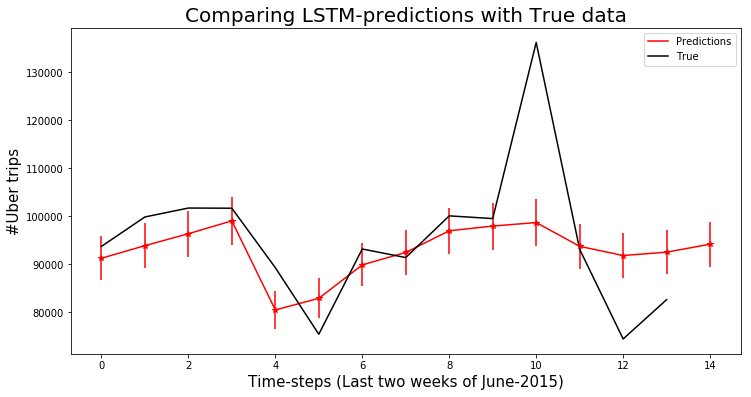

In [231]:
fig, ax = plt.subplots(figsize = (12,6))

e = [i*0.05 for i in pred]
ax.plot(pred, color = 'red', label = 'Predictions')
ax.errorbar(x = range(15), y = pred, yerr = e, fmt = '*', color = 'r')
ax.plot(test_jan_june, color = 'black', label = 'True')

ax.set_xlabel('Time-steps (Last two weeks of June-2015)', fontsize = 15)
ax.set_ylabel('#Uber trips', fontsize = 15)
ax.set_title('Comparing LSTM-predictions with True data', fontsize = 20)

ax.legend()
plt.show()

## How to bring back the actual time-series (i.e. series before log transformation and differencing)

## In this example ,it works: numbers are sorted

In [ ]:
a = pd.DataFrame({'col1': [1,2,3,4]})
print(a)

a['log'] = np.log10(a)
print(a)

a['log_shifted'] = a['log'] - a['log'].shift()
print(a)

a['back_shift'] = a['log_shifted'].cumsum()
a
a['back_shift_antilog'] = pd.Series([10**i for i in a['back_shift']])
a

## In this example, it doesn't work: Sorted but decreasing order
### Final reverse transformation is less by factor of 4 (see below)

In [ ]:
a = pd.DataFrame({'col1': [4,3,2,1]})
print(a)

a['log'] = np.log10(a)
print(a)

a['log_shifted'] = a['log'] - a['log'].shift()
print(a)

a['back_shift'] = a['log_shifted'].cumsum()
a
a['back_shift_antilog'] = pd.Series([10**i for i in a['back_shift']])
a

## In this example, numbers are random (i.e. something like real-world behavior)
### Behavior is still undesirable.

In [ ]:
a = pd.DataFrame({'col1': [30,11,52,400]})
print(a)

a['log'] = np.log10(a)
print(a)

a['log_shifted'] = a['log'] - a['log'].shift()
print(a)

a['back_shift'] = a['log_shifted'].cumsum()
a
a['back_shift_antilog'] = pd.Series([10**i for i in a['back_shift']])
a

In [ ]:
# from mpl_toolkits.basemap import Basemap
# plt.figure(figsize = (12,8))
# # m = Basemap(projection = 'mill', llcrnrlat= -90, llcrnrlon = -180, urcrnrlat = 90, urcrnrlon = 180, \
# #             resolution = 'i')

# m = Basemap(projection = 'mill', llcrnrlat= 20, llcrnrlon = -100, urcrnrlat = 50, urcrnrlon = -60, \
#             resolution = 'l')
# m.drawstates()
# m.drawcoastlines()
# m.fillcontinents()
# m.drawmapboundary()

# long, lat = uber_apr['Lon'], uber_apr['Lat']
# x, y = m(long, lat)
# m.plot(x, y, 'r.')
# plt.show()